# Banana Age Recognition

## Initial Directory Setup

Here we're defining the original directory where all the source images are stored. We also setup a make directory function and use that to set our train and validation directory.

In [68]:
import os
import numpy as np

def make_dir(directory):
    if os.path.exists(directory)==False:
        os.makedirs(directory)
        return(directory)
    else :
        return(directory)


img_dir = './images/dataset'

train_dir = make_dir('./images/train')
val_dir = make_dir('./images/val')


For this script, we'll be splitting the train and test data with predefined proportion of 0.8. We're taking the first 80% of the images as train, and the last 20% as validation. 

In [71]:
import random
import cv2
import shutil

train_proportion = 0.8
path = img_dir

for i in range(0,len(os.listdir(path))):
    classes = os.listdir(path)[i]
    file_path = path + "\\" + classes
    images = os.listdir(file_path)
    
    train_prop = round(len(images)*train_proportion)
    
    for i in range(0,len(images)):
        if i <= train_prop :
            src = file_path + '\\' + images[i]
            dst = make_dir(train_dir + '/'+classes+'/')
            shutil.copy(src,dst)

        else :
            src = file_path + '\\' + images[i]
            dst = make_dir(val_dir + '/' + classes + '/')
            shutil.copy(src,dst)

Creating ImageDataGenerator objects

In [72]:
from keras.preprocessing.image import ImageDataGenerator

bs = 8
img_size = 128
num_classes = 4


train_datagen = ImageDataGenerator(rotation_range = 50,
                                   width_shift_range=.1,
                                   height_shift_range=.1,
                                   shear_range=.2,
                                   zoom_range=.1,
                                   horizontal_flip=True,
                                  fill_mode = 'nearest')

val_datagen = ImageDataGenerator()


train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size = (img_size,img_size),
                                                   batch_size = bs
                                                    
                                                    
                                                   )

validation_generator = val_datagen.flow_from_directory(val_dir,
                                                      target_size = (img_size,img_size),
                                                      batch_size = bs,
                                                      shuffle = False)


Found 265 images belonging to 4 classes.
Found 62 images belonging to 4 classes.


In [73]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam

model = Sequential()

model.add(Conv2D(64,(3,3),input_shape = (train_generator.image_shape), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),input_shape = (train_generator.image_shape), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(256,(3,3), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))


model.add(Flatten())

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(num_classes))
model.add(Activation('softmax'))


opt = Adam(lr=0.001)

model.compile(optimizer=opt, metrics=['accuracy'], loss = 'categorical_crossentropy')

In [75]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('./banana_weights_v1.h5', monitor = 'val_accuracy',verbose = 1, save_best_only=True)

reducelr = ReduceLROnPlateau(patience = 5, monitor = 'val_accuracy', factor = 0.2, min_delta = 0.00001)

callbacks = [checkpoint, reducelr]

In [76]:

epochs = 50

history = model.fit_generator(train_generator,
                             steps_per_epoch=train_generator.n//train_generator.batch_size,
                              callbacks=callbacks,
                             epochs=epochs,
                              validation_data = validation_generator,
                              validation_steps = validation_generator.n//validation_generator.batch_size
                             )

Epoch 1/50
33/33 [==============================] - 20s 593ms/step - loss: 0.6526 - accuracy: 0.7704 - val_loss: 0.1516 - val_accuracy: 0.8214

Epoch 00001: val_accuracy improved from -inf to 0.82143, saving model to ./banana_weights_v1.h5
Epoch 2/50
33/33 [==============================] - 19s 575ms/step - loss: 0.6726 - accuracy: 0.8093 - val_loss: 0.2873 - val_accuracy: 0.7593

Epoch 00002: val_accuracy did not improve from 0.82143
Epoch 3/50
33/33 [==============================] - 22s 671ms/step - loss: 0.5021 - accuracy: 0.8210 - val_loss: 1.5567 - val_accuracy: 0.6111

Epoch 00003: val_accuracy did not improve from 0.82143
Epoch 4/50
33/33 [==============================] - 21s 641ms/step - loss: 0.4427 - accuracy: 0.8638 - val_loss: 0.1097 - val_accuracy: 0.5000

Epoch 00004: val_accuracy did not improve from 0.82143
Epoch 5/50
33/33 [==============================] - 19s 574ms/step - loss: 0.5370 - accuracy: 0.8093 - val_loss: 2.4981 - val_accuracy: 0.7778

Epoch 00005: val_ac

KeyboardInterrupt: 

## Accuracy rate per epoch

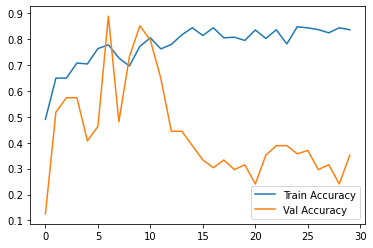

In [97]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.legend()

## Heatmap

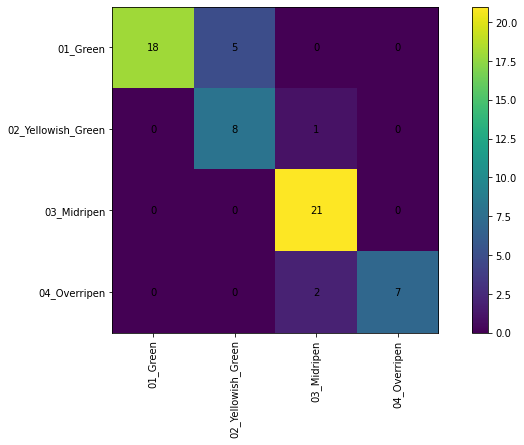

In [93]:
import matplotlib.pyplot as plt
from keras.preprocessing import image
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = banana_model.predict_generator(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

conf_mat = confusion_matrix(validation_generator.classes, y_pred)

class_labels = list(validation_generator.class_indices.keys())

plt.figure(figsize=(12,6))
plt.imshow(conf_mat)

for y in range(conf_mat.shape[0]):
    for x in range(conf_mat.shape[1]):
        plt.text(x , y , '%.0f' % conf_mat[y, x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 )
        
plt.colorbar()
tick_marks = np.arange(len(class_labels))
_=plt.xticks(tick_marks,class_labels,rotation=90)
_=plt.yticks(tick_marks,class_labels)

As we can see, currently the model is having difficulty identifying some images, because there is a bit of overlap in characteristics.

In [81]:
from keras.models import load_model
import matplotlib.pyplot as plt
from keras.preprocessing import image
import os
from os import listdir
import random
import cv2

banana_model = load_model('./banana_weights_v1.h5')
img_size = 128
test_path = val_dir

def getRandomImage(path, img_width, img_height):
    folder = listdir(path)
    random_folder_idx = random.randint(0,len(folder)-1)
    folder_name = folder[random_folder_idx]
    folder_path = path + '\\' + folder_name

    images = listdir(folder_path)
    random_img_idx = random.randint(0,len(images)-1)
    image_select = images[random_img_idx]
    full_path = folder_path + '\\' + image_select

    return image.load_img(full_path, target_size = (img_width,img_height)), full_path, folder_name

def draw_test(img_path, pred, true_label):

    image = cv2.imread(img_path)
    font_scale = .5

    expanded_image = cv2.copyMakeBorder(image, 100, 0,0,0, cv2.BORDER_CONSTANT, value=[0,0,0])
    cv2.putText(expanded_image, "Prediction : " + pred,org=(10, 30),fontFace=cv2.FONT_HERSHEY_COMPLEX, color=(0,0,255), fontScale = font_scale)
    cv2.putText(expanded_image, "True Labels : " + true_label,org=(10, 50),fontFace=cv2.FONT_HERSHEY_COMPLEX, color=(0,255,0), fontScale = font_scale)
    cv2.imshow("Image",expanded_image)




In [2]:
banana_dict = {
    '0' : 'Green',
    '1' : 'Yellowish_Green',
    '2' : 'Midripen',
    '3' : 'Overripen',
}

In [102]:
import numpy as np

for i in range(0,10):
    
    pic, full_path, class_label = getRandomImage(test_path, img_size, img_size)
    img = np.asarray(pic)
    img = img.reshape((1,) + img.shape)

    class_predict = banana_model.predict_classes(img)
    class_predict_label = banana_dict.get(str(class_predict[0]))
#     print(banana_model.predict(img))
    draw_test(full_path, class_label, class_predict_label)

    cv2.waitKey(0)

cv2.destroyAllWindows()



In [100]:
img = image.load_img(r'D:\PROJECTS_ML\Banana_recognition\images\test\banana_bunch_2.jpg', target_size = (128,128))
img = np.asarray(pic)
img = img.reshape((1,) + img.shape)

class_predict = banana_model.predict_classes(img)
class_predict_label = banana_dict.get(str(class_predict[0]))
print(banana_model.predict(img))
print(class_predict_label)
# draw_test(full_path, class_label, class_predict_label)

[[3.9833028e-02 9.2667669e-01 3.2929886e-02 5.6043168e-04]]
Yellowish_Green


In [4]:
list(banana_dict.values())

['Green', 'Yellowish_Green', 'Midripen', 'Overripen']

# Importing Banana Classifier

This step needs to be done so that we can utilize camera to detect our banana

In [4]:
import cv2
from keras.models import load_model
import numpy as np
from time import sleep
from keras.preprocessing.image import img_to_array

model = load_model('./banana_weights_v1.h5')

face_classifier = cv2.CascadeClassifier(r'D:\PROJECTS_ML\Banana_recognition\BananaCascade.xml')


class_labels = ['Green', 'Yellowish_Green', 'Midripen', 'Overripen']



def face_detector(img):
    # Convert image to grayscale
#     gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(img, 1.3, 5)
    
    if faces is ():
        return (0,0,0,0), np.zeros((50,50), np.uint8), img
    
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = img[y:y+h, x:x+w]

    try:
        roi_gray = cv2.resize(roi_gray, (128, 128), interpolation = cv2.INTER_AREA)
    except:
        return (x,w,y,h), np.zeros((48,48), np.uint8), img
    return (x,w,y,h), roi_gray, img

cap = cv2.VideoCapture(0)

while True:

    ret, frame = cap.read()
    rect, face, image = face_detector(frame)
    if np.sum([face]) != 0.0:
        roi = face
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis=0)

        # make a prediction on the ROI, then lookup the class
        preds = model.predict(roi)[0]
        label = class_labels[preds.argmax()]  
        label_position = (rect[0] + int((rect[1]/2)), rect[2] + 25)
        cv2.putText(image, label, label_position , cv2.FONT_HERSHEY_SIMPLEX,2, (0,255,0), 3)
    else:
        cv2.putText(image, "No Face Found", (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,2, (0,255,0), 3)
        
    cv2.imshow('All', image)
    if cv2.waitKey(1) == 13: #13 is the Enter Key
        break
        
cap.release()
cv2.destroyAllWindows()      

<>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-4-d9f97f3acfd3>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if faces is ():
